***
# EDA, Classification (Random Forest Classification)

<br><br>
### Group 4
### Big Geodata Processing
<br> 
<br> 
*September 2019*


### EDA ANALYSIS

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import dask
import dask.dataframe as dd
import dask.array as da 

from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

In [2]:
# path to input files for data processing
pwd = r'C:\Users\owoey\Documents\ITC_MSc_Program\M-GEO\Big Geoddata Processing\Data Management\Practical\Dataset'
path_temp = r'\temperature.csv'
path_prec = r'\precipitation.csv'
path_land = r'\observed_landuse\Obs_landuse.csv'   
data = r'\RF.csv'
path_bio = r'\biodiversity.csv'
path_obs = r'\Observer_count.csv'

In [3]:
# reads the path for observed dataset
df = pd.read_csv(pwd+r'\observed.csv', parse_dates=['obsdate'])

In [4]:
df.head()

,id,species,observer,obsdate,obstime,block,geom,mdate,odate,doy,dow,natholiday
0,1526450,xzPs99AUN2kjSr,UVbfZTjmVhh8ae,2017-04-30,08:30,18254,010300002040710000010000000500000000000000804F...,20170430,2017-04-30,120,0,f
1,1526470,fwRudRXVbLMlJn,UVbfZTjmVhh8ae,2017-04-29,07:39,18254,010300002040710000010000000500000000000000804F...,20170429,2017-04-29,119,6,f
2,1526459,gw8tyjUXM2RfVm,UVbfZTjmVhh8ae,2017-04-30,09:15,18254,010300002040710000010000000500000000000000804F...,20170430,2017-04-30,120,0,f
3,1526410,yiUIPVaLBmQGPh,BW.qUQE0.y32C/,2017-05-20,07:35,18254,010300002040710000010000000500000000000000804F...,20170520,2017-05-20,140,6,f
4,1526473,rJkJjeCZFbPWdJ,UVbfZTjmVhh8ae,2017-04-29,07:42,18254,010300002040710000010000000500000000000000804F...,20170429,2017-04-29,119,6,f


In [5]:
df.dtypes

id                     int64
species               object
observer              object
obsdate       datetime64[ns]
obstime               object
block                  int64
geom                  object
mdate                  int64
odate                 object
doy                    int64
dow                    int64
natholiday            object
dtype: object

In [6]:
# reads the path for temperature dataset

df_tmp = pd.read_csv(pwd+path_temp, parse_dates=['dtime'])

In [10]:
# reads the path for precipitation dataset

df_pcp = pd.read_csv(pwd+path_prec, parse_dates=['dtime'])

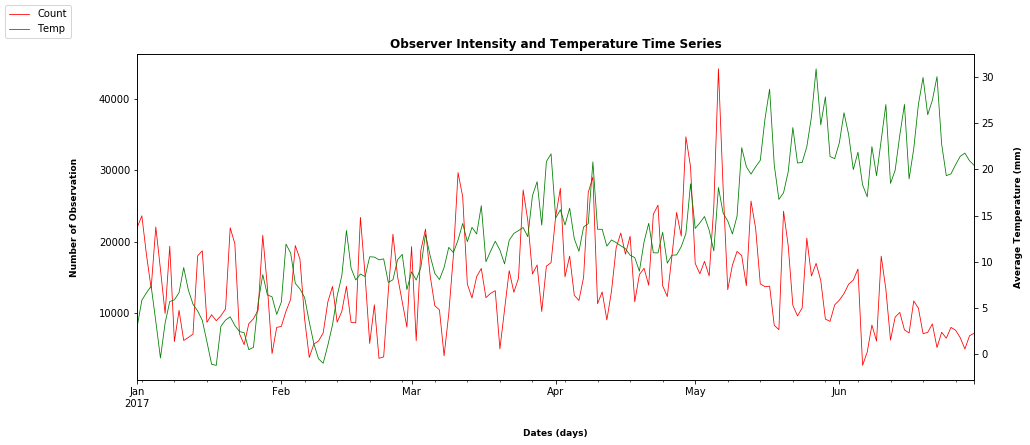

In [7]:
# groupby date and then plot the full time series including the average temperature 

ax = plt.figure()
obs = df.groupby(['obsdate']).size().plot(figsize=(15,4), lw=0.8, c='r', label='Count')
temp = df_tmp.groupby(['dtime'])['temper'].mean().plot(figsize=(15,6), secondary_y=True, lw=0.8, c='g', label='Temp')
ax.legend(loc='upper left')

# styling the graph

obs.set_xlabel("Dates (days)", labelpad=20, weight='bold', size=9)
obs.set_ylabel("Number of Observation", labelpad=20, weight='bold', size=9)
temp.set_ylabel("Average Temperature (mm)", labelpad=20, weight='bold', size=9) 


plt.title('Observer Intensity and Temperature Time Series', weight='bold', size=12)
plt.savefig(pwd+r'\TimeSeries_Temp.png', format='png')



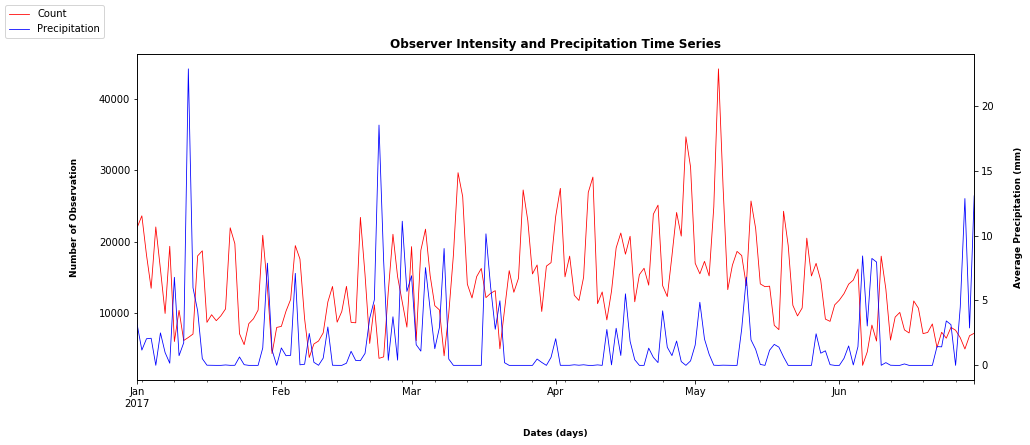

In [11]:
# groupby date and then plot the full time series including the average temperature 

ax = plt.figure()
obs = df.groupby(['obsdate']).size().plot(figsize=(15,4), lw=0.8, c='r', label='Count')
precip = df_pcp.groupby(['dtime'])['precip'].mean().plot(figsize=(15,6), secondary_y=True, lw=0.8, c='b', label='Precipitation')
ax.legend(loc='upper left')

# styling the graph

obs.set_xlabel("Dates (days)", labelpad=20, weight='bold', size=9)
obs.set_ylabel("Number of Observation", labelpad=20, weight='bold', size=9)
precip.set_ylabel("Average Precipitation (mm)", labelpad=20, weight='bold', size=9) 


plt.title('Observer Intensity and Precipitation Time Series', weight='bold', size=12)
plt.savefig(pwd+r'\TimeSeries_Precip.png', format='png')


In [12]:
df['month'] = df['obsdate'].dt.month

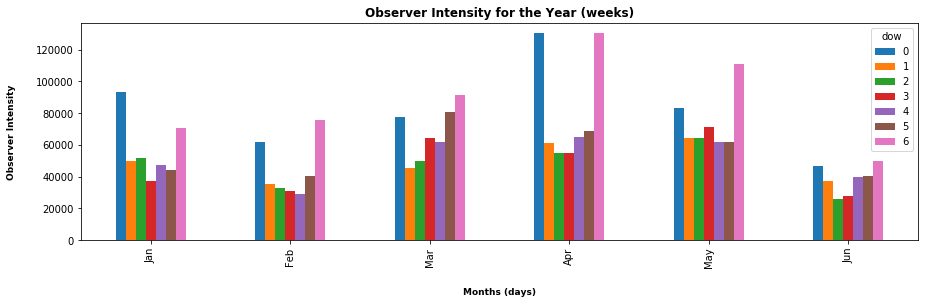

<Figure size 432x288 with 0 Axes>

In [13]:
# bar chart that shows Observer Intensity for each week in the year
dow = df.groupby(['dow']).month.value_counts().unstack(0).plot.bar(figsize = (15,4))

## styling 
dow.set_title('Observer Intensity for the Year (weeks)', weight='bold', size=12)
dow.set_xticklabels(('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'))
dow.set_xlabel("Months (days)", labelpad=20, weight='bold', size=9)
dow.set_ylabel("Observer Intensity", labelpad=20, weight='bold', size=9)


plt.show()
plt.savefig(pwd+r'\Observer Intensity.png', format='png')


In [14]:
# reads the path for raw dataset

cols = ['temp', 'precip', 'road_length', 'category', 'obscount']
df_final = pd.read_csv(pwd+data, index_col=0)

In [15]:
df_final.head()

,obscount,temp,precip,road_length,blockk,category
block,,,,,,
60,1,13.557460,1.483658,900.487334,60.0,Water
61,8,13.525533,1.477029,1656.383770,61.0,Water
62,4,13.504900,1.471720,5180.104665,62.0,Recreatie
63,34,13.484402,1.466738,12690.696436,63.0,Water
64,19,13.464183,1.462753,2792.363673,64.0,Semi-bebouwd


In [16]:
# missing data

df_final.isna().sum()

obscount          0
temp           2546
precip         2546
road_length    2546
blockk           33
category         33
dtype: int64

In [17]:
# drop missing values

df_final.dropna(subset=['temp', 'precip', 'road_length'], inplace=True)
df_final.isna().sum()

obscount       0
temp           0
precip         0
road_length    0
blockk         0
category       0
dtype: int64

In [18]:
# defining the class range for the observer intensity

def set_range(row):
    if row["obscount"] < 10:
        return "low"
    elif row["obscount"] <50:
        return "medium"
    elif row["obscount"] >=50:
        return "high"
    
df_final = df_final.assign(classification=df_final.apply(set_range, axis=1))

In [19]:
# removing unwanted columns

df_final.drop(columns=['obscount', 'blockk'], inplace=True)

In [20]:
# reads the path for biodiversity and observer count dataset

df_bio = pd.read_csv(pwd+path_bio, index_col='block')
df_obs = pd.read_csv(pwd+path_obs, index_col='blockk')

# merge all datasets together to create data for classification of observer intensity

dataset = df_obs.merge(df_bio, left_index=True, right_index=True).merge(df_final, left_index=True, right_index=True)

In [24]:
dataset.head()

,count,aves2012_2016,temp,precip,road_length,category,classification
60,1,16,13.557460,1.483658,900.487334,Water,low
61,2,25,13.525533,1.477029,1656.383770,Water,low
62,4,13,13.504900,1.471720,5180.104665,Recreatie,low
63,9,66,13.484402,1.466738,12690.696436,Water,medium
64,10,40,13.464183,1.462753,2792.363673,Semi-bebouwd,medium


In [29]:
# renaming biodiversity column

dataset.rename(columns={'aves2012_2016' : 'biodiversity'}, inplace=True)

In [30]:
# summary statistics

dataset.describe()

,count,biodiversity,temp,precip,road_length
count,30842.00000,30842.000000,30842.000000,30842.000000,30842.000000
mean,12.08148,51.404319,13.399612,1.870603,4744.662370
std,25.01592,36.652597,0.664277,0.178298,4800.465541
min,1.00000,0.000000,11.580000,1.368069,0.000000
25%,3.00000,23.000000,12.869332,1.748439,1786.446350
50%,6.00000,43.000000,13.490612,1.884828,3014.440442
75%,12.00000,71.000000,13.834822,1.990628,5598.180858
max,861.00000,252.000000,14.575845,2.363759,33998.706768


In [31]:
# correlation table for the dataset

dataset.corr()

,count,biodiversity,temp,precip,road_length
count,1.000000,0.576130,-0.053437,-0.088491,0.014187
biodiversity,0.576130,1.000000,0.012207,-0.121834,0.091994
temp,-0.053437,0.012207,1.000000,-0.355737,0.158801
precip,-0.088491,-0.121834,-0.355737,1.000000,-0.071992
road_length,0.014187,0.091994,0.158801,-0.071992,1.000000


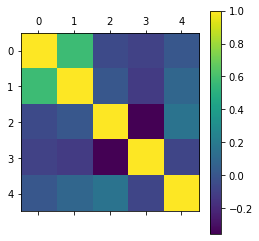

In [32]:
# correlation map

plt.matshow(dataset.corr())
plt.colorbar()

In [33]:
# class results 

class_counts = dataset.groupby('classification').size()
print(class_counts)

classification
high       8703
low       11024
medium    11115
dtype: int64


In [34]:
# summarize dataset
# columns

dataset.columns

Index(['count', 'biodiversity', 'temp', 'precip', 'road_length', 'category',
       'classification'],
      dtype='object')

In [35]:
# summarize dataset
# shape

print(dataset.shape)

(30842, 7)


In [36]:
# summary statistics

print(dataset.describe())

             count  biodiversity          temp        precip   road_length
count  30842.00000  30842.000000  30842.000000  30842.000000  30842.000000
mean      12.08148     51.404319     13.399612      1.870603   4744.662370
std       25.01592     36.652597      0.664277      0.178298   4800.465541
min        1.00000      0.000000     11.580000      1.368069      0.000000
25%        3.00000     23.000000     12.869332      1.748439   1786.446350
50%        6.00000     43.000000     13.490612      1.884828   3014.440442
75%       12.00000     71.000000     13.834822      1.990628   5598.180858
max      861.00000    252.000000     14.575845      2.363759  33998.706768


classification
high       8703
low       11024
medium    11115
dtype: int64


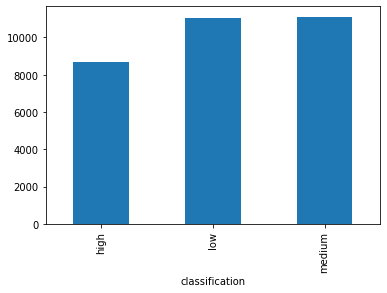

In [37]:
# class distribution

print(dataset.groupby('classification').size())

# barchart showing the class distribution
dataset.groupby('classification').size().plot.bar()

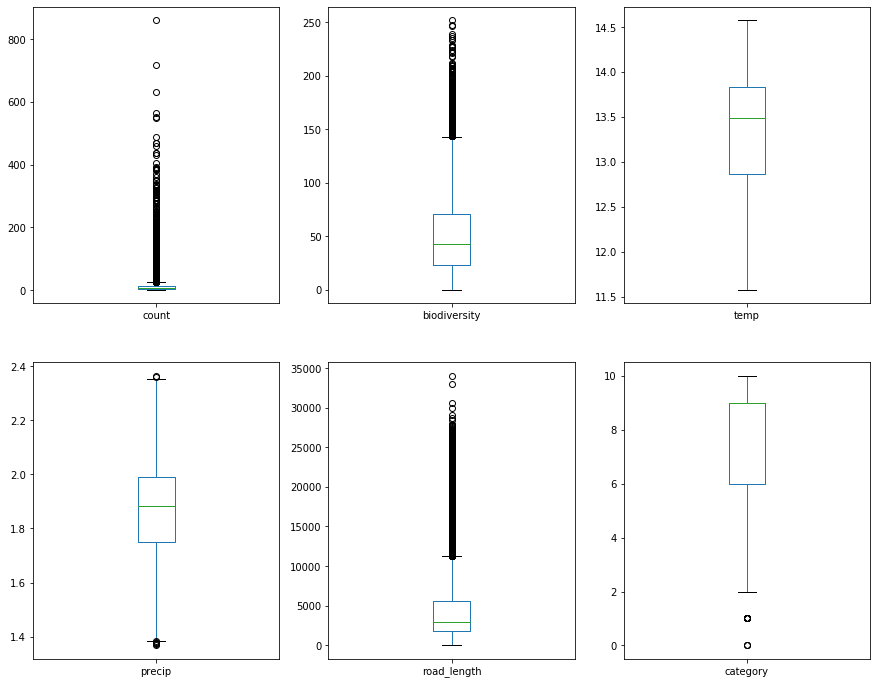

<Figure size 432x288 with 0 Axes>

In [52]:
# box and whisker plots

dataset.plot(figsize=(15,12), kind='box', subplots=True, layout=(2,3), sharex=False, sharey=False)
plt.show()
plt.savefig(pwd+r'\Boxplot.png', format='png')

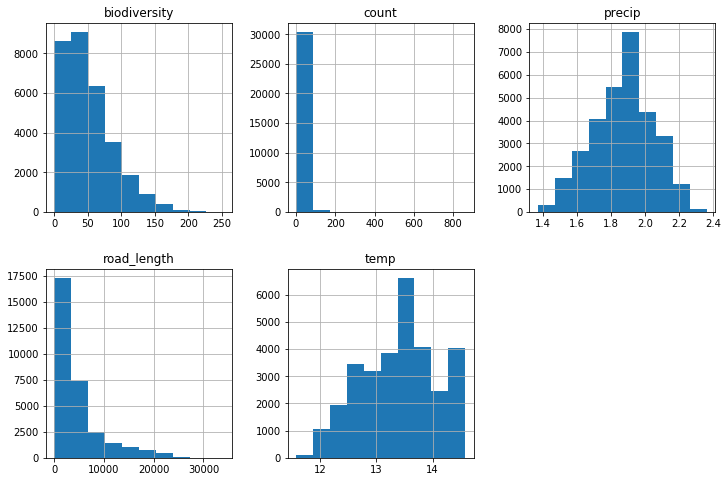

<Figure size 432x288 with 0 Axes>

In [39]:
# histograms

dataset.hist(figsize=(12,8), layout=(2,3))
plt.show()
plt.savefig(pwd+r'\Histograms.png', format='png')

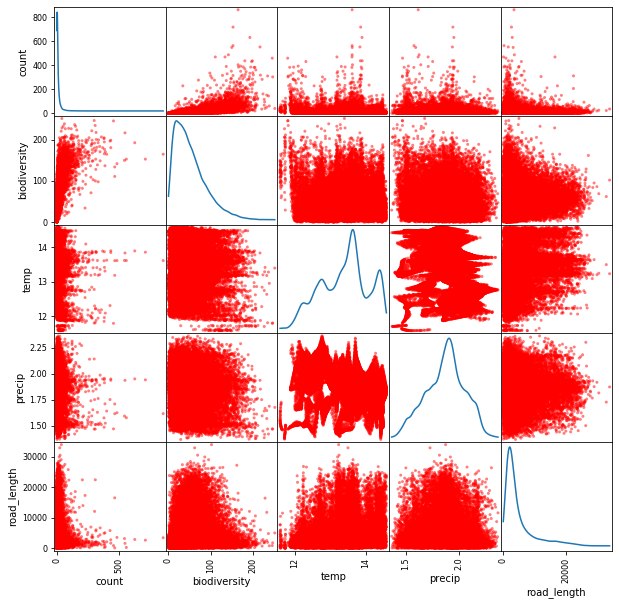

In [40]:
# scatter plot matrix

scatter_matrix(dataset, figsize=(10,10), diagonal='kde', c='r')
plt.show()

## Modelling - Random Forest Classfication

In [41]:
# selection of unique landuse category

dataset.category.unique()

array(['Water', 'Recreatie', 'Semi-bebouwd', 'nature reserves',
       'Landbouw', 'Nat natuurlijk terrein', 'Spoorweg', 'Vliegveld',
       'Droog natuurlijk terrein', 'Hoofdweg', 'Bos'], dtype=object)

In [42]:
# encoding the landuse category

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le = LabelEncoder()
le.fit(list(dataset.category.unique()))
dataset['category_encoded'] = le.transform(dataset['category'])


In [43]:
dataset.head()

,count,biodiversity,temp,precip,road_length,category,classification,category_encoded
60,1,16,13.557460,1.483658,900.487334,Water,low,9
61,2,25,13.525533,1.477029,1656.383770,Water,low,9
62,4,13,13.504900,1.471720,5180.104665,Recreatie,low,5
63,9,66,13.484402,1.466738,12690.696436,Water,medium,9
64,10,40,13.464183,1.462753,2792.363673,Semi-bebouwd,medium,6


In [44]:
# renaming the encoded category 

dataset['category'] = dataset['category_encoded']

In [45]:
# deleting the unwanted columns

dataset.drop(columns=['category_encoded'], inplace=True)

In [46]:
dataset.head()

,count,biodiversity,temp,precip,road_length,category,classification
60,1,16,13.557460,1.483658,900.487334,9,low
61,2,25,13.525533,1.477029,1656.383770,9,low
62,4,13,13.504900,1.471720,5180.104665,5,low
63,9,66,13.484402,1.466738,12690.696436,9,medium
64,10,40,13.464183,1.462753,2792.363673,6,medium


In [47]:
# Split-out validation dataset

array = dataset.values
X = array[:,0:6]
Y = array[:,6]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed, stratify=Y)

In [48]:
# Spot-Check Algorithms

models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=250)))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='f1_weighted')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

CART: 0.687583 (0.004163)
RF: 0.765867 (0.004581)
SVM: 0.372606 (0.006269)


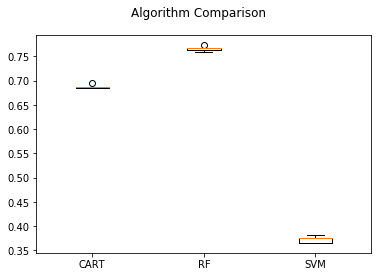

In [49]:
# Compare Algorithms

fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [50]:
# hyperparameter tuning

# Tune scaled GBM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
scoring = 'f1_weighted'

param_grid = dict(n_estimators=np.array([20,50,100,200,250,400]), min_samples_leaf=np.array([1,2,5,10]))
model = RandomForestClassifier(random_state=seed, n_jobs=-1)

kfold = KFold(n_splits=5, random_state=seed)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)

grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.772426 using {'min_samples_leaf': 10, 'n_estimators': 200}
0.757763 (0.002841) with: {'min_samples_leaf': 1, 'n_estimators': 20}
0.763441 (0.003679) with: {'min_samples_leaf': 1, 'n_estimators': 50}
0.764662 (0.004642) with: {'min_samples_leaf': 1, 'n_estimators': 100}
0.765438 (0.004090) with: {'min_samples_leaf': 1, 'n_estimators': 200}
0.764947 (0.003985) with: {'min_samples_leaf': 1, 'n_estimators': 250}
0.765543 (0.003686) with: {'min_samples_leaf': 1, 'n_estimators': 400}
0.763702 (0.004954) with: {'min_samples_leaf': 2, 'n_estimators': 20}
0.767612 (0.004539) with: {'min_samples_leaf': 2, 'n_estimators': 50}
0.767702 (0.005068) with: {'min_samples_leaf': 2, 'n_estimators': 100}
0.766589 (0.004294) with: {'min_samples_leaf': 2, 'n_estimators': 200}
0.767155 (0.004218) with: {'min_samples_leaf': 2, 'n_estimators': 250}
0.768006 (0.005094) with: {'min_samples_leaf': 2, 'n_estimators': 400}
0.767941 (0.004621) with: {'min_samples_leaf': 5, 'n_estimators': 20}
0.770248 (0.004

In [51]:
# random forest classification

from sklearn.metrics import f1_score

RFc = RandomForestClassifier(min_samples_leaf=10, n_estimators=200, n_jobs=-1, random_state=seed)
RFc.fit(rescaledX, Y_train)

rescaledValidationX = scaler.transform(X_validation)
predictions = RFc.predict(rescaledValidationX)


print(f1_score(Y_validation, predictions, average='weighted'))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.7682437902403241
0.7680337169719565
[[1313   26  402]
 [   0 1874  331]
 [ 251  421 1551]]
              precision    recall  f1-score   support

        high       0.84      0.75      0.79      1741
         low       0.81      0.85      0.83      2205
      medium       0.68      0.70      0.69      2223

    accuracy                           0.77      6169
   macro avg       0.78      0.77      0.77      6169
weighted avg       0.77      0.77      0.77      6169

